# House Prices: Advanced Regression Techniques

## Случайный лес и градиентный бустинг над решающими деревьями

Необходимо предсказать цену недвижимости по имеющимся описаниям домов. Это задача из конкурса Kaggle, с условиями и описанием признаков можно ознакомиться здесь: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

В первой части решения будут использоваться RandomForest и GradietnBoosting. 
* Подбор параметров будем осуществлять поиском по сетке GridSearchCV и RandomizedSearchCV на кросс-валидации по 3-м блокам. 
* Выбор лучшей модели - по отложенной выборке. 
* Метрика качества - RMSE над логарифмом целевой переменной.
* В качестве кодирования категориальных признаков будем использовать специальный метод кодирования для решающих деревьев. 
* Обработка пропущенных значений: медиана для числовых признаков, новое значение - для категориальных.

In [36]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer

import time

import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline

## Загрузка данных

In [2]:
data_train = pd.read_csv('train.csv', index_col = 'Id')
data_train[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## Предобработка данных

#### Целевая переменная

Рассмотрим целевую переменную. В качестве метрики для оценки качества алгоритмов в конкурсе используется RMSE над логарифмами цен. Это делается для того, чтобы ошибки при определении цены дорогой и дешевой недвижимости имели одинаковый вес. Поэтому мы также будем обучать модели на логарифме от исходной целевой переменной.

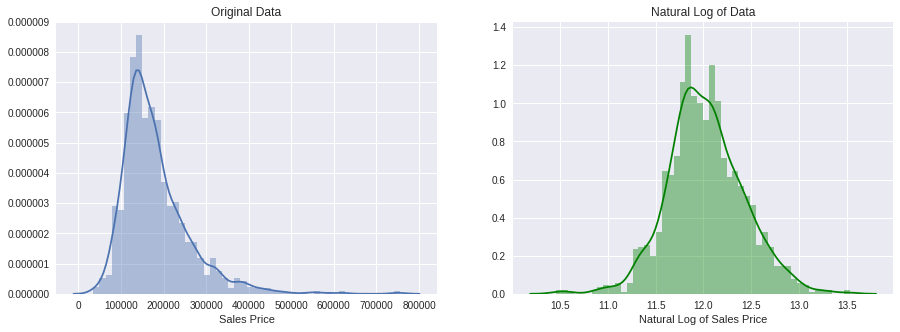

In [3]:
y = np.log(data_train['SalePrice'])

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.distplot(data_train['SalePrice'], bins = 50)
plt.title('Original Data')
plt.xlabel('Sales Price')

plt.subplot(1, 2, 2)
sns.distplot(y, bins = 50, color = 'g')
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sales Price')

#### Заполнение пропусков

Рассмотрим теперь матрицу объекты - признаки. Для начала разделим все признаки на два типа: числовые и категориальные, поскольку мы будем обрабатывать их по-разному.

In [4]:
numeric_cols = []
categorical_cols = []
for column in data_train.drop('SalePrice', axis = 1, inplace = False).columns.values:
    if data_train[column].dtype == 'object':
        categorical_cols.append(column)
    else:
        numeric_cols.append(column)

# Некоторые признаки, имеющие в качестве значений числа, тем не менее являются
# категориальными. Использование их как числовых ведет к ухудшению результата
for feature in ['MSSubClass', 'MoSold']:
    numeric_cols.remove(feature)
    categorical_cols.append(feature)

Посмотрим, сколько и в каких колонках есть пропуски:

In [5]:
print('Number of missing values in columns:')
for i in range(0, len(data_train.columns)):
    if data_train.ix[:, i].isnull().sum() != 0:
        print (data_train.columns[i], ': ', data_train.ix[:, i].isnull().sum())

Number of missing values in columns:
LotFrontage :  259
Alley :  1369
MasVnrType :  8
MasVnrArea :  8
BsmtQual :  37
BsmtCond :  37
BsmtExposure :  38
BsmtFinType1 :  37
BsmtFinType2 :  38
Electrical :  1
FireplaceQu :  690
GarageType :  81
GarageYrBlt :  81
GarageFinish :  81
GarageQual :  81
GarageCond :  81
PoolQC :  1453
Fence :  1179
MiscFeature :  1406


Необходимо отметить, что для многих признаков nan - это отдельное значение. Например, nan в GarageType и других признаках, описывающих состояние гаража, означает, что гаража вообще нет. В основном такое правило соблюдается для категориальных и порядковых признаков. Поэтому мы будем заменять пропуски новой категорией nan. 

In [6]:
data_train[categorical_cols].fillna('Null')
X_cat = pd.DataFrame(data_train[categorical_cols].applymap(str))
X_cat.isnull().values.any()

False

Для числовых признаков лучше заменить пропуски на медиану, так обучение будет более устойчиво к выбросам.

In [7]:
X_num = pd.DataFrame(columns = numeric_cols)
for i in range(0, len(data_train[numeric_cols].columns)):
    X_num.ix[:, i] = data_train[numeric_cols].ix[:, i].fillna(data_train[numeric_cols].ix[:, i].median())
X_num.isnull().values.any()

False

#### Формирование отложенной выборки

In [8]:
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size = 0.3, random_state = 0)
X_cat_train, X_cat_test = train_test_split(X_cat, test_size = 0.3, random_state = 0)

#### Кодирование категориальных признаков

В выборке у нас очень много категориальных признаков, хочется использовать эти данные на обучении. Однако применение one-hot encoding сильно увеличит количество признаков и затруднит работу с деревьями. Поэтому мы будем использовать специальный способ кодирования для решающих деревьев. К сожалению, не нашла готовую функцию в библиотеках, поэтому реализовала ее здесь.

Здесь использован подход из курса https://www.coursera.org/learn/supervised-learning/home/week/4. Кодирование производится следующим образом:

* Значения для каждого признака сортируются в порядке увеличения среднего ответа по всем объектам с такими значениями:

$$\frac{\sum_{i\subset X_m} [x_i^j = c_{(1)}]y_i}{\sum_{i\subset X_m} [x_i^j = c_{(1)}]} \leq \:...\: \leq \frac{\sum_{i\subset X_m} [x_i^j = c_{(n)}]y_i}{\sum_{i\subset X_m} [x_i^j = c_{(n)}]},$$

  где:
$X_m$ - подвыборка объектов с одинаковыми значениями признака $c_{(1)}$, 
$x_i^j$ - значение j-го признака на i-м объекте, 
$y_i$ - значение целевой переменной на i-м объекте.


* Эти значения $c_{(1)}, \:...\:, c_{(n)}$ заменяются на последовательность 1, ..., n
* Далее работаем с категориальными признаками как с числовыми

Таким способом мы в какой-то мере сохраняем значения признаков и их влияние на целевую переменную, не увеличивая количество признаков.

In [9]:
# Функция формирует маппинг старых значений на новые
# для одного признака
def get_map(feature_train, y_train):
    feature_map = pd.DataFrame() # здесь будет храниться маппинг

    for label in feature_train.unique():
        # для каждого уникального значения считаем среднее для целевой переменной
        feature_map.ix[label, 'Proportion'] = y_train[feature_train == label].sum() / \
        float(feature_train.value_counts()[label])
    
    # сортируем значения и получаем новые значения от 1 до n
    feature_map.sort_values(by = 'Proportion', inplace = True)
    feature_map[feature_train.name] = np.arange(1, len(feature_map) + 1)
    
    return feature_map[feature_train.name]

In [10]:
# Функция кодирует признаки на обучающей выборке 
# и формирует маппинг для всех признаков
def cat_encode_fit_transform(X_train, y_train):
    
    X_train_encoded = X_train.copy() # здесь будут новые значения
    map_train = [] # здесь будет маппинг старых значений на новые для всех признаков
    
    for feature_num in range(0, len(X_train.columns)):
        # для каждого признака получаем маппинг
        feature_map = get_map(X_train.ix[:, feature_num], y_train)
        map_train.append(feature_map)
        
        # заменяем предыдущие значения на новые
        for index in X_train.index:
            for label in feature_map.index:
                if X_train.ix[index, feature_num] == label:
                    X_train_encoded.ix[index, feature_num] = feature_map[label]
                    continue
                    
    return X_train_encoded, map_train

In [11]:
# Функция кодирует признаки на тестовой выборке,
# используя маппинг, полученный при кодировании обучающей выборки
def cat_encode_transform(X_test, map_train):
    
    X_test_encoded = X_test.copy() # здесь будут новые значения
    map_test = [] # здесь будет новый маппинг, в который могут быть добавлены
    # значения признаков, которых не было в обучающей выборке
    
    # Копируем маппинг с обучения
    for feature_num in range(0, len(map_train)):
        map_test.append(map_train[feature_num].copy())
    
    for feature_num in range(0, len(X_test.columns)):
        # Для каждого признака сравниваем его значения с маппингом
        for index in X_test.index:
            index_encoded = False # признак закодированного значения
            
            for encode_label in map_test[feature_num].index:
                
                if X_test.ix[index, feature_num] == encode_label:
                    X_test_encoded.ix[index, feature_num] = map_test[feature_num][encode_label]
                    index_encoded = True
                    continue
                    
            # если значение из тестовой выборки не встречалось на обучении, кодируем 0
            if not index_encoded:
                map_test[feature_num][X_test.ix[index, feature_num]] = 0
                X_test_encoded.ix[index, feature_num] = 0
    
    return X_test_encoded, map_test

Для демонстрации работы приведем простой пример. Зададим два DataFrame, обучающий и тестовый:

In [12]:
# Обучающая выборка
basket_train = pd.DataFrame(np.array([['Apple', 'Apple', 'Orange', 'Apricot'], \
                                     ['Green', 'Yellow', 'Yellow', 'Yellow']]).T, \
                            columns = ['Fruit', 'Color'])
# Целевая переменная
basket_target = pd.Series(np.array([2, 5, 4, 3]), name = 'Count')

# Тестовая выборка
basket_test = pd.DataFrame(np.array([['Apple', 'Banana', 'Orange', 'Apricot'], \
                                     ['Green', 'Pink', 'Yellow', 'Yellow']]).T, \
                            columns = ['Fruit', 'Color'])

Итак, в тестовой выборке у нас появился розовый банан, которого не было на обучении. Мы используем количество фруктов 'Count' в качестве целевой переменной. Попробуем теперь закодировать обучающую выборку:

In [13]:
basket_train_encoded, basket_train_map = cat_encode_fit_transform(basket_train, basket_target)
print('Train sample: ')
print(pd.concat([basket_train, basket_target], axis = 1))
print()
print('Encoded train:')
print(basket_train_encoded)
print()
print('Train map:')
print(basket_train_map[0])
print(basket_train_map[1])

Train sample: 
     Fruit   Color  Count
0    Apple   Green      2
1    Apple  Yellow      5
2   Orange  Yellow      4
3  Apricot  Yellow      3

Encoded train:
  Fruit Color
0     2     1
1     2     2
2     3     2
3     1     2

Train map:
Apricot    1
Apple      2
Orange     3
Name: Fruit, dtype: int64
Green     1
Yellow    2
Name: Color, dtype: int64


Так Apple получает код 2, т.к. среднее по колонке 'Count' для него (2 + 5) / 2 = 3.5, в то время как для Orange это 4. Теперь закодируем тестовую выборку:

In [14]:
basket_test_encoded, basket_test_map = cat_encode_transform(basket_test, basket_train_map)
print('Test sample: ')
print(basket_test)
print()
print('Encoded test:')
print(basket_test_encoded)
print()
print('Test map:')
print(basket_test_map[0])
print(basket_test_map[1])

Test sample: 
     Fruit   Color
0    Apple   Green
1   Banana    Pink
2   Orange  Yellow
3  Apricot  Yellow

Encoded test:
  Fruit Color
0     2     1
1     0     0
2     3     2
3     1     2

Test map:
Apricot    1
Apple      2
Orange     3
Banana     0
Name: Fruit, dtype: int64
Green     1
Yellow    2
Pink      0
Name: Color, dtype: int64


У Pink и Banana мы видим код 0, т.к. этих значений не было в обучающей выборке. Теперь мы можем закодировать категориальные признаки в нашей задаче. Это займет некоторое время.

In [15]:
%%time
X_cat_train_encoded, map_train = cat_encode_fit_transform(X_cat_train, y_train)

CPU times: user 1min 4s, sys: 96 ms, total: 1min 4s
Wall time: 1min 4s


In [16]:
%%time
X_cat_test_encoded, map_test = cat_encode_transform(X_cat_test, map_train)

CPU times: user 26.9 s, sys: 52 ms, total: 26.9 s
Wall time: 26.8 s


#### Формирование итоговых обучающей и тестовой выборки

In [17]:
X_train = np.hstack([X_num_train, X_cat_train_encoded])
X_test = np.hstack([X_num_test, X_cat_test_encoded])

## Обучение моделей

#### Scorer и Grid Search

Здесь мы определим некоторые полезные функции, которые помогут при обучении моделей.

In [18]:
# Scorer будет использоваться при поиске по сетке
# на кросс-валидации
def score_func(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

scorer = make_scorer(score_func, greater_is_better = False)

In [19]:
# Функция организует поиск по сетке лучшего алгоритма 
# и выводит результаты
def GridSearch(estimator, param_grid, X_train = X_train, y_train = y_train, cv = 3, scorer = None, random_grid = False):
        
    if random_grid:
        grid = RandomizedSearchCV(estimator, param_grid, cv = 3, scoring = scorer, random_state = 0)
    else:
        grid = GridSearchCV(estimator, param_grid, cv = 3, scoring = scorer)
    
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    
    print('Best estimator:\n', grid.best_estimator_)
    print()
    print('Best score:\n', - grid.best_score_)
    print()
    print('Scores:\n', grid.grid_scores_[:5])
    print()
    print('Time elapsed: ', end - start, 'sec')
    
    return grid.best_estimator_

In [20]:
# Функция выводит результат на тестовой выборке
def get_score(estimator, X_test = X_test, y_test = y_test):
    y_pred = estimator.predict(X_test)
    
    print('RMSE on test sample: ', \
          np.sqrt(mean_squared_error(y_test, y_pred)))
    
    plt.scatter(y_test, y_pred)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')

### Random Forest

Поскольку Random Forest обучается довольно долго, для начала организуем случайный поиск по сетке.

In [21]:
RF = RandomForestRegressor()

random_param_grid_RF = {
    'max_depth' : np.arange(3, 100),
    'max_features' : np.arange(3, 79),
    'n_estimators' : np.arange(5, 1000),
    'n_jobs' : [5],
    'random_state' : [0]
}

GridSearch(RF, random_param_grid_RF, random_grid = True, scorer = scorer)

Best estimator:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=71,
           max_features=18, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=619, n_jobs=5,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Best score:
 0.1398629781953413

Scores:
 [mean: -0.14070, std: 0.01594, params: {'random_state': 0, 'n_jobs': 5, 'n_estimators': 630, 'max_features': 41, 'max_depth': 62}, mean: -0.14269, std: 0.01547, params: {'random_state': 0, 'n_jobs': 5, 'n_estimators': 865, 'max_features': 50, 'max_depth': 22}, mean: -0.14080, std: 0.01613, params: {'random_state': 0, 'n_jobs': 5, 'n_estimators': 239, 'max_features': 25, 'max_depth': 32}, mean: -0.13986, std: 0.01656, params: {'random_state': 0, 'n_jobs': 5, 'n_estimators': 619, 'max_features': 18, 'max_depth': 71}, mean: -0.14436, std: 0.01607, params: {'random_state': 0, 'n_jobs': 5, 'n_estimat

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=71,
           max_features=18, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=619, n_jobs=5,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
param_grid_RF = {
    'max_depth' : np.arange(60, 80, 5),
    'max_features' : np.arange(15, 22, 3),
    'n_estimators' : np.arange(500, 700, 50),
    'n_jobs' : [5],
    'random_state' : [0]
}

RF_best = GridSearch(RF, param_grid_RF, scorer = scorer)

Best estimator:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features=18, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=5,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Best score:
 0.13962835595182307

Scores:
 [mean: -0.14021, std: 0.01651, params: {'max_depth': 60, 'max_features': 15, 'n_estimators': 500, 'n_jobs': 5, 'random_state': 0}, mean: -0.14025, std: 0.01657, params: {'max_depth': 60, 'max_features': 15, 'n_estimators': 550, 'n_jobs': 5, 'random_state': 0}, mean: -0.14034, std: 0.01654, params: {'max_depth': 60, 'max_features': 15, 'n_estimators': 600, 'n_jobs': 5, 'random_state': 0}, mean: -0.14042, std: 0.01660, params: {'max_depth': 60, 'max_features': 15, 'n_estimators': 650, 'n_jobs': 5, 'random_state': 0}, mean: -0.13963, std: 0.01650, params: {'max_depth': 60, 'max_features': 18, 'n_e

RMSE on test sample:  0.122770734821


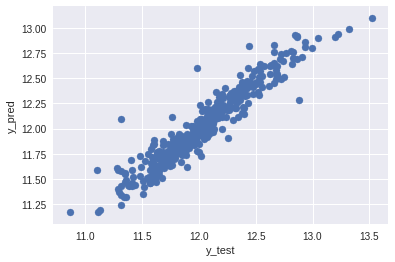

In [23]:
get_score(RF_best)

### Gradient Boosting

Здесь мы также будем использовать поиск по сетке.

In [24]:
GB = GradientBoostingRegressor()

random_param_grid_GB = {
    'alpha' : np.arange(0.01, 1.00, 0.01),
    'max_depth' : np.arange(1, 5),
    'n_estimators' : np.arange(10, 1000, 10),
    'max_features' : [10, 20, 40, 60, 79],
    'random_state' : [0],
}

GridSearch(GB, random_param_grid_GB, random_grid = True, scorer = scorer)

Best estimator:
 GradientBoostingRegressor(alpha=0.59999999999999998, criterion='friedman_mse',
             init=None, learning_rate=0.1, loss='ls', max_depth=3,
             max_features=20, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=440, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

Best score:
 0.12717088925265976

Scores:
 [mean: -0.16079, std: 0.01614, params: {'random_state': 0, 'n_estimators': 80, 'max_features': 10, 'max_depth': 1, 'alpha': 0.23000000000000001}, mean: -0.13471, std: 0.01344, params: {'random_state': 0, 'n_estimators': 400, 'max_features': 79, 'max_depth': 3, 'alpha': 0.88}, mean: -0.12717, std: 0.01420, params: {'random_state': 0, 'n_estimators': 440, 'max_features': 20, 'max_depth': 3, 'alpha': 0.59999999999999998}, mean: -0.12900, std: 0.01266, params: {'random_state': 0, 'n_estimators': 51

GradientBoostingRegressor(alpha=0.59999999999999998, criterion='friedman_mse',
             init=None, learning_rate=0.1, loss='ls', max_depth=3,
             max_features=20, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=440, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [25]:
param_grid_GB = {
    'alpha' : np.arange(0.1, 1.0, 0.1),
    'max_depth' : np.arange(2, 4),
    'n_estimators' : np.arange(300, 600, 50),
    'max_features' : np.arange(10, 30, 5),
    'random_state' : [0]
}

GB_best = GridSearch(GB, param_grid_GB, scorer = scorer)

Best estimator:
 GradientBoostingRegressor(alpha=0.10000000000000001, criterion='friedman_mse',
             init=None, learning_rate=0.1, loss='ls', max_depth=2,
             max_features=15, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=350, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

Best score:
 0.12557400575390282

Scores:
 [mean: -0.12877, std: 0.01402, params: {'alpha': 0.10000000000000001, 'max_depth': 2, 'max_features': 10, 'n_estimators': 300, 'random_state': 0}, mean: -0.12833, std: 0.01385, params: {'alpha': 0.10000000000000001, 'max_depth': 2, 'max_features': 10, 'n_estimators': 350, 'random_state': 0}, mean: -0.12831, std: 0.01362, params: {'alpha': 0.10000000000000001, 'max_depth': 2, 'max_features': 10, 'n_estimators': 400, 'random_state': 0}, mean: -0.12837, std: 0.01381, params: {'alpha': 0.1000000000

RMSE on test sample:  0.119906557731


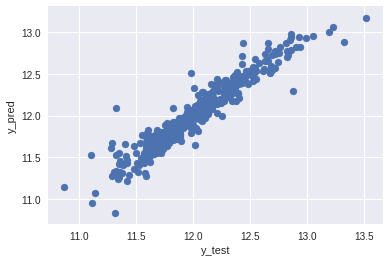

In [26]:
get_score(GB_best)

## Предсказание результатов на тестовой выборке

Поскольку лучший результат показал Gradient Boosting, мы будем использовать его для формирования результатов на тесте.

### Загрузка данных

In [27]:
data_test = pd.read_csv('test.csv', index_col = 'Id')
data_test[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### Предобработка данных

#### Заполнение пропусков

In [28]:
print('Number of missing values in columns:')
for i in range(0, len(data_test.columns)):
    if data_test.ix[:, i].isnull().sum() != 0:
        print (data_test.columns[i], ': ', data_test.ix[:, i].isnull().sum())

Number of missing values in columns:
MSZoning :  4
LotFrontage :  227
Alley :  1352
Utilities :  2
Exterior1st :  1
Exterior2nd :  1
MasVnrType :  16
MasVnrArea :  15
BsmtQual :  44
BsmtCond :  45
BsmtExposure :  44
BsmtFinType1 :  42
BsmtFinSF1 :  1
BsmtFinType2 :  42
BsmtFinSF2 :  1
BsmtUnfSF :  1
TotalBsmtSF :  1
BsmtFullBath :  2
BsmtHalfBath :  2
KitchenQual :  1
Functional :  2
FireplaceQu :  730
GarageType :  76
GarageYrBlt :  78
GarageFinish :  78
GarageCars :  1
GarageArea :  1
GarageQual :  78
GarageCond :  78
PoolQC :  1456
Fence :  1169
MiscFeature :  1408
SaleType :  1


In [29]:
data_test[categorical_cols].fillna('Null')
X_cat_test_sample = pd.DataFrame(data_test[categorical_cols].applymap(str))
X_cat_test_sample.isnull().values.any()

False

In [30]:
X_num_test_sample = pd.DataFrame(columns = numeric_cols)
for i in range(0, len(data_test[numeric_cols].columns)):
    X_num_test_sample.ix[:, i] = data_test[numeric_cols].ix[:, i].fillna(data_test[numeric_cols].ix[:, i].median())
X_num_test_sample.isnull().values.any()

False

#### Кодирование категориальных признаков

In [31]:
%%time
X_cat_train_sample_encoded, map_train_final = cat_encode_fit_transform(X_cat, y)

CPU times: user 1min 29s, sys: 192 ms, total: 1min 30s
Wall time: 1min 29s


In [32]:
%%time
X_cat_test_sample_encoded, map_test_final = cat_encode_transform(X_cat_test_sample, map_train_final)

CPU times: user 1min 32s, sys: 332 ms, total: 1min 32s
Wall time: 1min 31s


#### Формирование итоговых обучающей и тестовой выборок

In [33]:
X_train_sample = np.hstack([X_num, X_cat_train_sample_encoded])
X_test_sample = np.hstack([X_num_test_sample, X_cat_test_sample_encoded])

### Обучение моделей

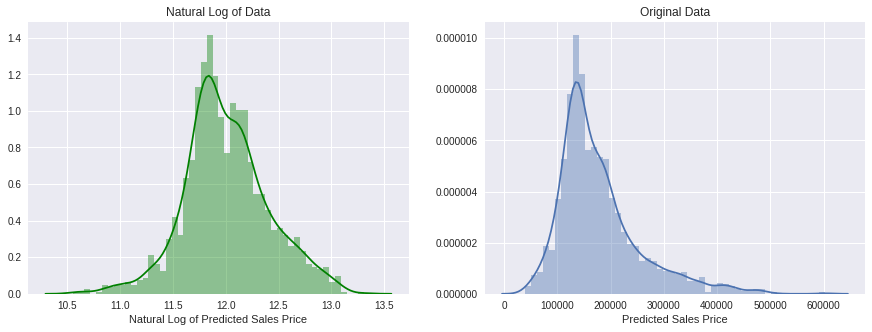

In [34]:
GB_best.fit(X_train_sample, y)
predictions = GB_best.predict(X_test_sample)
answers = np.exp(predictions)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
sns.distplot(predictions, bins = 50, color = 'g')
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Predicted Sales Price')

plt.subplot(1, 2, 2)
sns.distplot(answers, bins = 50)
plt.title('Original Data')
plt.xlabel('Predicted Sales Price')

Распределения целевой переменной и логарифма на тесте выглядят аналогично обучающей выборке. Это, конечно, не строгая оценка, но тем не менее в какой-то мере исключает грубые ошибки.

### Экспорт данных

In [35]:
pd.DataFrame(answers, index = data_test.index, columns = ['SalePrice']).to_csv('answers_GB')